In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data

In [67]:
df = pd.read_csv("data-filter/merged.csv")
X = df.to_numpy()[:, 1:]
y = df['symbol_id'].to_numpy()

In [68]:
n_samples, n_features = X.shape

In [69]:
X.shape, y.shape

((1387, 784), (1387,))

# scale to 0-1

In [70]:
X = X/255.0

# show data

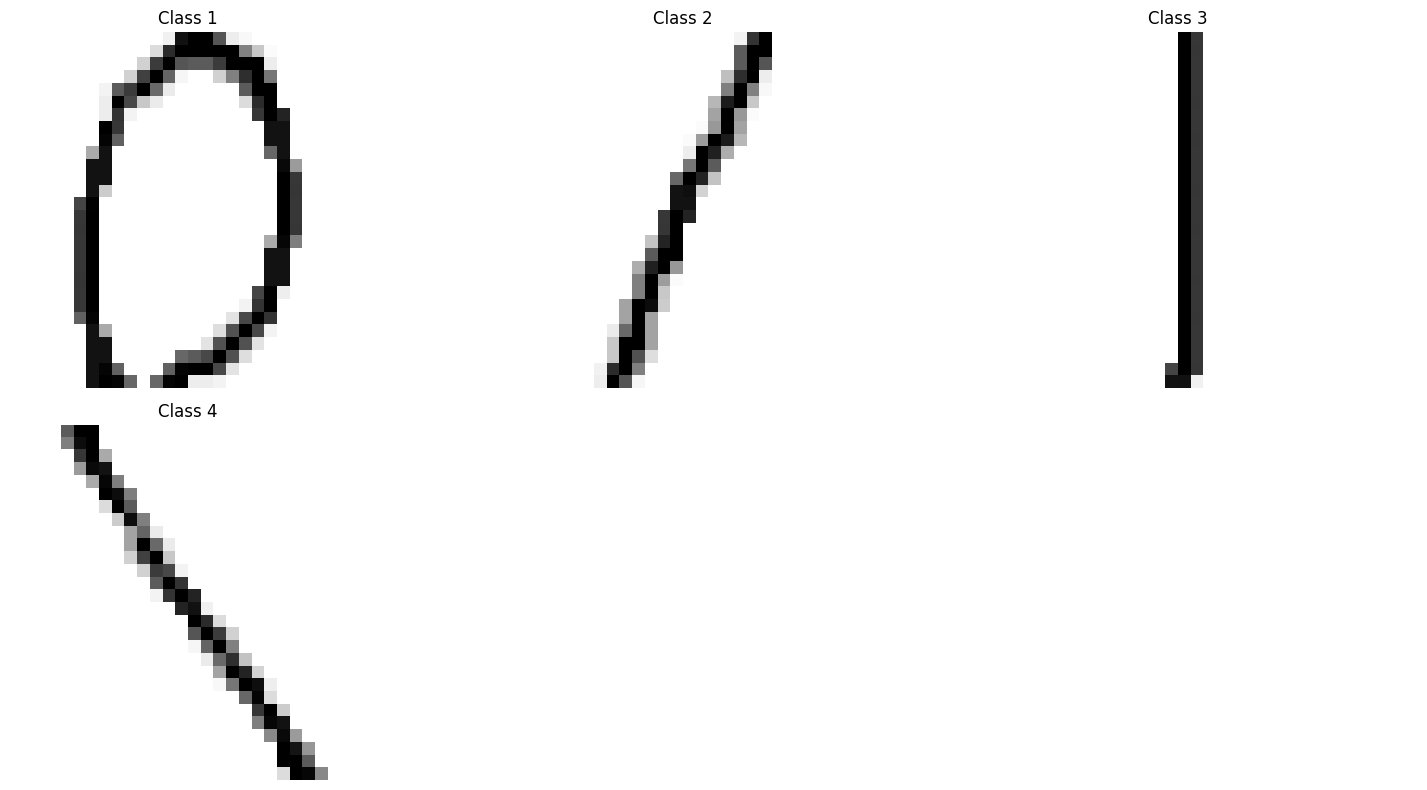

{0: False, 1: True, 2: True, 3: True, np.int64(4): True}


In [71]:
character_mapping = {i: False for i in range(len(np.unique(y)))}
for label in np.unique(y):
    character_mapping[label] = True

# Draw a representative image for each class
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, label in enumerate(np.unique(y)):
    # Find the first occurrence of this label
    sample_idx = np.where(y == label)[0][0]
    sample_image = X[sample_idx].reshape(28, 28)
    axes[idx].imshow(sample_image, cmap='gray')
    axes[idx].set_title(f'Class {label}')
    axes[idx].axis('off')

# Hide any unused subplots
for ax in axes[len(np.unique(y)):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

print(character_mapping)

# train test split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# PCA

In [73]:
# fit
n_components = 10

X_train_std = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)

corr = 1/(X_train.shape[0] - 1) * X_train_std.T @ X_train_std

U, S, Vt = np.linalg.svd(corr)

np.save("pca_components.npy", U[:, :n_components])
np.save("pca_explained_variance.npy", S[:n_components])
np.save("mean.npy", X_train.mean(axis=0))
np.save("std.npy", X_train.std(axis=0))

# transform
X_train_reduced = X_train_std @ U[:, :n_components]
X_test_std = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test_reduced = X_test_std @ U[:, :n_components]
print(X_train_reduced.shape)
print(X_test_reduced.shape)


(1109, 10)
(278, 10)


# train mlp

In [74]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
model.fit(X_train_reduced, y_train)

,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(100,)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",300
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        17
           2       1.00      0.99      1.00       107
           3       0.99      0.99      0.99       102
           4       0.98      1.00      0.99        52

    accuracy                           0.99       278
   macro avg       0.99      1.00      0.99       278
weighted avg       0.99      0.99      0.99       278



Text(0.5, 1.0, 'Confusion Matrix')

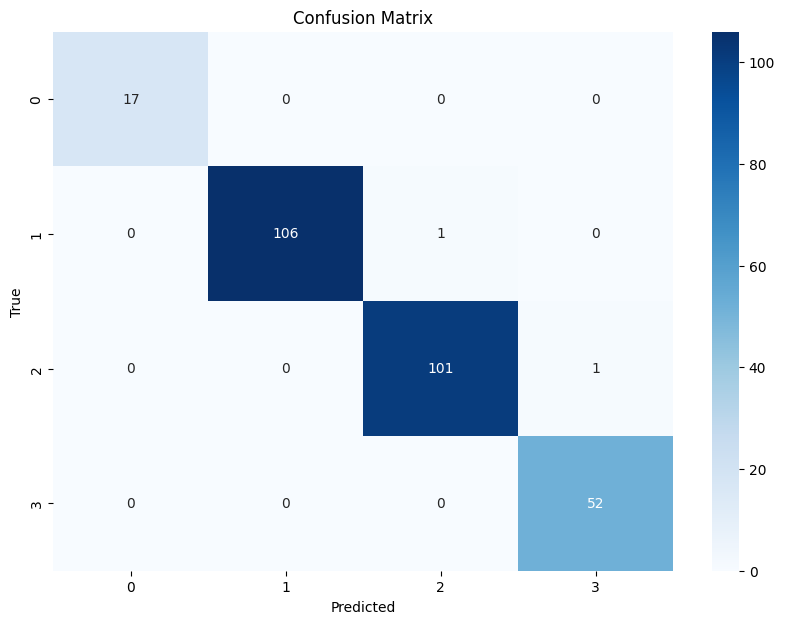

In [75]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_reduced)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# save model

In [76]:
import joblib
joblib.dump(model, "character_classifier.pkl")

['character_classifier.pkl']